In [ ]:
!nvidia-smi

Wed Dec 28 00:55:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    28W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install diffusers==0.11.1
!pip install transformers scipy ftfy accelerate
!pip install "ipywidgets>=7,<8"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
from PIL import Image, ImageDraw
import cv2
import numpy as np
from IPython.display import HTML
from base64 import b64encode

import torch
from torch import autocast
from torch.nn import functional as F
from diffusers import StableDiffusionPipeline, AutoencoderKL
from diffusers import UNet2DConditionModel, PNDMScheduler, LMSDiscreteScheduler
from diffusers.schedulers.scheduling_ddim import DDIMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from tqdm.auto import tqdm
from huggingface_hub import notebook_login
from google.colab import output

device = 'cuda'

output.enable_custom_widget_manager()
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


In [ ]:
# make sure you're logged in with `huggingface-cli login`
pipe = StableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4", revision='fp16',
    torch_dtype=torch.float16, use_auth_token=True)
pipe = pipe.to(device)

Downloading:   0%|          | 0.00/543 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.63k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/608M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/307 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/572 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/246M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/788 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

  0%|          | 0/50 [00:00<?, ?it/s]

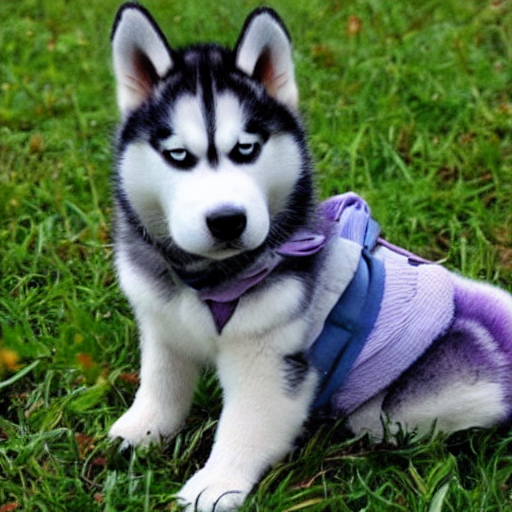

In [ ]:
prompt = 'a cute husky dog'
torch.cuda.empty_cache()
with autocast(device):
  image = pipe(prompt).images[0]
image

In [ ]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

  0%|          | 0/50 [00:00<?, ?it/s]

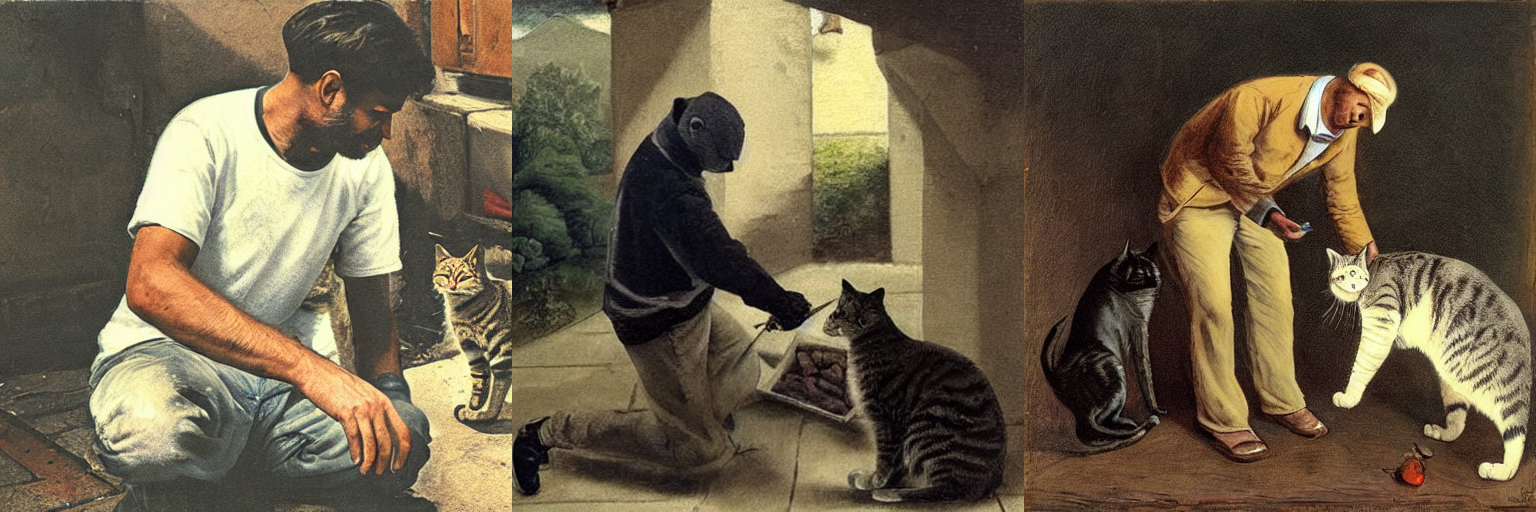

In [ ]:
n_images = 3
prompts = ['a man feed a cat'] * n_images
torch.cuda.empty_cache()
with autocast(device):
  images = pipe(prompts, num_inference_steps=50).images
image_grid(images, rows=1, cols=3)

#Custom Pipeline

In [ ]:
# 1. Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained(
    'CompVis/stable-diffusion-v1-4', subfolder='vae', use_auth_token=True)
vae = vae.to(device)

# 2. Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-large-patch14')
text_encoder = CLIPTextModel.from_pretrained('openai/clip-vit-large-patch14')
text_encoder = text_encoder.to(device)

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained(
    'CompVis/stable-diffusion-v1-4', subfolder='unet', use_auth_token=True)
unet = unet.to(device)

# 4. Create a scheduler for inference
scheduler = LMSDiscreteScheduler(
    beta_start=0.00085, beta_end=0.012,
    beta_schedule='scaled_linear', num_train_timesteps=1000)

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.13.self_attn.k_proj.weight', 'vision_model.encoder.layers.3.self_attn.v_proj.bias', 'vision_model.encoder.layers.0.self_attn.k_proj.weight', 'vision_model.encoder.layers.22.self_attn.v_proj.bias', 'vision_model.encoder.layers.8.self_attn.out_proj.weight', 'vision_model.encoder.layers.7.mlp.fc1.weight', 'vision_model.encoder.layers.21.self_attn.k_proj.bias', 'vision_model.encoder.layers.19.mlp.fc1.weight', 'vision_model.encoder.layers.12.mlp.fc2.bias', 'vision_model.encoder.layers.3.mlp.fc2.weight', 'vision_model.encoder.layers.11.self_attn.out_proj.weight', 'vision_model.encoder.layers.1.layer_norm1.bias', 'vision_model.encoder.layers.10.layer_norm2.weight', 'vision_model.encoder.layers.4.self_attn.v_proj.weight', 'vision_model.encoder.layers.10.layer_norm2.bias', 'vision_model.encoder.layers.21.self_attn.out_proj.weight', 'vision_model.enco

In [ ]:
def get_text_embeds(prompt):
  # Tokenize text and get embeddings
  text_input = tokenizer(
      prompt, padding='max_length', max_length=tokenizer.model_max_length,
      truncation=True, return_tensors='pt')
  with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

  # Do the same for unconditional embeddings
  uncond_input = tokenizer(
      [''] * len(prompt), padding='max_length',
      max_length=tokenizer.model_max_length, return_tensors='pt')
  with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]

  # Cat for final embeddings
  text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
  return text_embeddings

test_embeds = get_text_embeds(['cute dog'])
print(test_embeds)
print(test_embeds.shape)

tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [-0.3711, -1.4497, -0.3401,  ...,  0.9489,  0.1867, -1.1034],
         [-0.5107, -1.4629, -0.2926,  ...,  1.0419,  0.0701, -1.0284],
         ...,
         [ 0.5006, -0.9552, -0.6610,  ...,  1.6013, -1.0622, -0.2191],
         [ 0.4988, -0.9451, -0.6656,  ...,  1.6467, -1.0858, -0.2088],
         [ 0.4923, -0.8124, -0.4912,  ...,  1.6108, -1.0174, -0.2484]],

        [[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [-0.4771, -0.4680,  0.0514,  ..., -0.1052, -0.4885,  0.0188],
         [-2.0088,  0.5783,  0.3972,  ..., -1.1441, -0.9926, -0.6557],
         ...,
         [-0.6084, -0.0921,  0.2035,  ...,  0.1636, -1.3557, -1.4459],
         [-0.6007, -0.0966,  0.2229,  ...,  0.1646, -1.3530, -1.4512],
         [-0.5907, -0.0834,  0.2733,  ...,  0.1987, -1.3098, -1.4578]]],
       device='cuda:0')
torch.Size([2, 77, 768])


In [ ]:
def produce_latents(text_embeddings, height=512, width=512,
                    num_inference_steps=50, guidance_scale=7.5, latents=None):
  if latents is None:
    latents = torch.randn((text_embeddings.shape[0] // 2, unet.in_channels, \
                           height // 8, width // 8))
  latents = latents.to(device)

  scheduler.set_timesteps(num_inference_steps)
  latents = latents * scheduler.init_noise_sigma

  with autocast('cuda'):
    for i, t in tqdm(enumerate(scheduler.timesteps)):
      # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
      latent_model_input = torch.cat([latents] * 2)
      sigma = scheduler.sigmas[i]
      latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

      # predict the noise residual
      with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)['sample']

      # perform guidance
      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
      noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

      # compute the previous noisy sample x_t -> x_t-1
      latents = scheduler.step(noise_pred, t, latents)['prev_sample']
  
  return latents

test_latents = produce_latents(test_embeds)
print(test_latents)
print(test_latents.shape)

0it [00:00, ?it/s]

tensor([[[[ 4.8242e-01,  6.5352e-01,  8.9948e-01,  ...,  1.2582e+00,
            7.5055e-01,  8.3906e-01],
          [ 6.7865e-01,  9.3072e-01,  6.2292e-01,  ...,  1.3618e+00,
            1.3749e+00,  1.5680e+00],
          [ 1.1008e+00,  8.1379e-01,  1.3751e+00,  ...,  1.0526e+00,
            1.6361e+00,  3.5483e-01],
          ...,
          [-8.8191e-02,  1.0966e-01,  2.8940e-01,  ...,  7.5684e-01,
            8.8510e-01, -1.8967e-01],
          [ 2.4842e-01,  3.3388e-01,  6.9513e-01,  ...,  7.1674e-01,
            5.3339e-01,  5.9088e-01],
          [-3.7191e-01,  8.9982e-02,  2.4885e-01,  ...,  1.4774e-02,
           -4.2371e-01,  1.2224e-01]],

         [[-1.0481e-01,  3.0504e-01,  1.5334e-01,  ...,  3.1394e-01,
           -9.3249e-02,  5.1695e-01],
          [ 1.1174e-02,  2.1014e-01, -3.4496e-01,  ...,  6.1760e-03,
           -7.5982e-01,  6.7068e-01],
          [ 3.8045e-01, -1.7688e-01, -2.0333e-01,  ..., -5.7342e-02,
           -3.1890e-01,  2.2687e-01],
          ...,
     

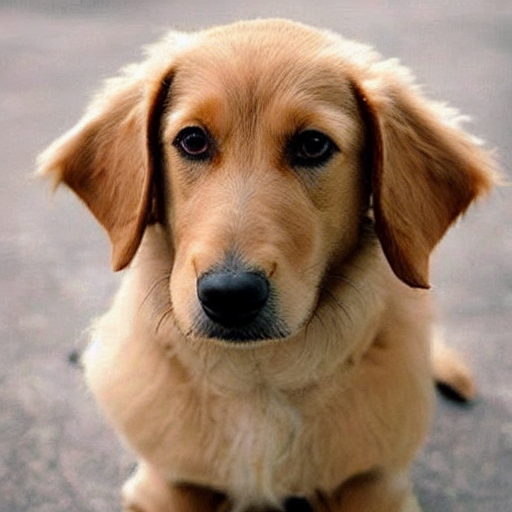

In [ ]:
def decode_img_latents(latents):
  latents = 1 / 0.18215 * latents

  with torch.no_grad():
    image = vae.decode(latents).sample

  image = (image / 2 + 0.5).clamp(0, 1)
  image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
  images = (image * 255).round().astype("uint8")
  pil_images = [Image.fromarray(image) for image in images]
  return pil_images

imgs = decode_img_latents(test_latents)
imgs[0]

In [ ]:
def prompt_to_img(prompts, height=512, width=512, num_inference_steps=50,
                  guidance_scale=7.5, latents=None):
  if isinstance(prompts, str):
    prompts = [prompts]

  # Prompts -> text embeds
  text_embeds = get_text_embeds(prompts)

  # Text embeds -> img latents
  latents = produce_latents(
      text_embeds, height=height, width=width, latents=latents,
      num_inference_steps=num_inference_steps, guidance_scale=guidance_scale)
  
  # Img latents -> imgs
  imgs = decode_img_latents(latents)

  return imgs

0it [00:00, ?it/s]

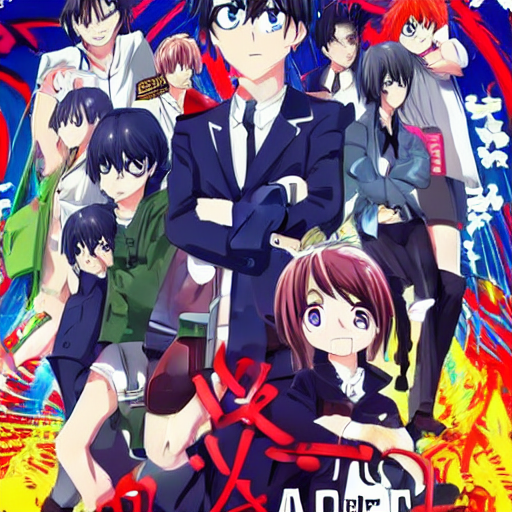

In [ ]:
torch.cuda.empty_cache()
prompt_to_img('a super cool anime', 512, 512, 20)[0]

#Make a Video

In [ ]:
def produce_latents(text_embeddings, height=512, width=512,
                    num_inference_steps=50, guidance_scale=7.5, latents=None,
                    return_all_latents=False):
  if latents is None:
    latents = torch.randn((text_embeddings.shape[0] // 2, unet.in_channels, \
                           height // 8, width // 8))
  latents = latents.to(device)

  scheduler.set_timesteps(num_inference_steps)
  latents = latents * scheduler.init_noise_sigma

  latent_hist = [latents]
  with autocast('cuda'):
    for i, t in tqdm(enumerate(scheduler.timesteps)):
      # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
      latent_model_input = torch.cat([latents] * 2)
      sigma = scheduler.sigmas[i]
      latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

      # predict the noise residual
      with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)['sample']

      # perform guidance
      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
      noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

      # compute the previous noisy sample x_t -> x_t-1
      latents = scheduler.step(noise_pred, t, latents)['prev_sample']
      latent_hist.append(latents)
  
  if not return_all_latents:
    return latents

  all_latents = torch.cat(latent_hist, dim=0)
  return all_latents

def prompt_to_img(prompts, height=512, width=512, num_inference_steps=50,
                  guidance_scale=7.5, latents=None, return_all_latents=False,
                  batch_size=2):
  if isinstance(prompts, str):
    prompts = [prompts]

  # Prompts -> text embeds
  text_embeds = get_text_embeds(prompts)

  # Text embeds -> img latents
  latents = produce_latents(
      text_embeds, height=height, width=width, latents=latents,
      num_inference_steps=num_inference_steps, guidance_scale=guidance_scale,
      return_all_latents=return_all_latents)
  
  # Img latents -> imgs
  all_imgs = []
  for i in tqdm(range(0, len(latents), batch_size)):
    imgs = decode_img_latents(latents[i:i+batch_size])
    all_imgs.extend(imgs)

  return all_imgs

In [ ]:
prompt = 'a man surfing on the beach'
torch.cuda.empty_cache()
video_frames = prompt_to_img(
    prompt, num_inference_steps=40, return_all_latents=True)

0it [00:00, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

In [ ]:
len(video_frames)

41

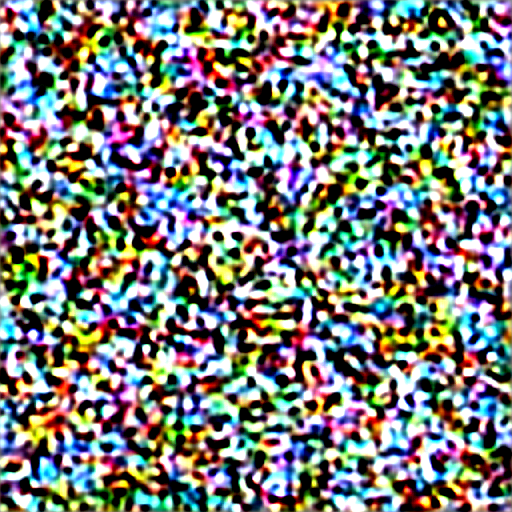

In [ ]:
video_frames[0]

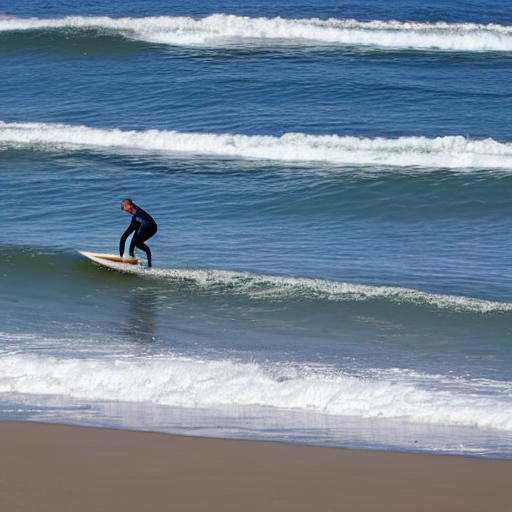

In [ ]:
video_frames[-1]

In [ ]:
def imgs_to_video(imgs, video_name='video.mp4', fps=15):
  video_dims = (imgs[0].width, imgs[0].height)
  fourcc = cv2.VideoWriter_fourcc(*'DIVX')    
  video = cv2.VideoWriter(video_name, fourcc, fps, video_dims)
  for img in imgs:
    tmp_img = img.copy()
    video.write(cv2.cvtColor(np.array(tmp_img), cv2.COLOR_RGB2BGR))
  video.release()

def display_video(file_path, width=512):
  compressed_vid_path = 'comp_' + file_path
  if os.path.exists(compressed_vid_path):
    os.remove(compressed_vid_path)
  os.system(f'ffmpeg -i {file_path} -vcodec libx264 {compressed_vid_path}')

  mp4 = open(compressed_vid_path, 'rb').read()
  data_url = 'data:simul2/mp4;base64,' + b64encode(mp4).decode()
  return HTML("""
    <video width={} controls>
          <source src="{}" type="video/mp4">
    </video>
    """.format(width, data_url))

Trường hợp không load được video truy cập theo đường link này: https://colab.research.google.com/drive/1eySWrf0mpdmNIVOQXdlCkkTwoL2VzhQg?usp=sharing


In [ ]:
vid_name = prompt.replace(' ', '_') + '.mp4'
imgs_to_video(video_frames, vid_name)
display_video(vid_name)

#Similar Img

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

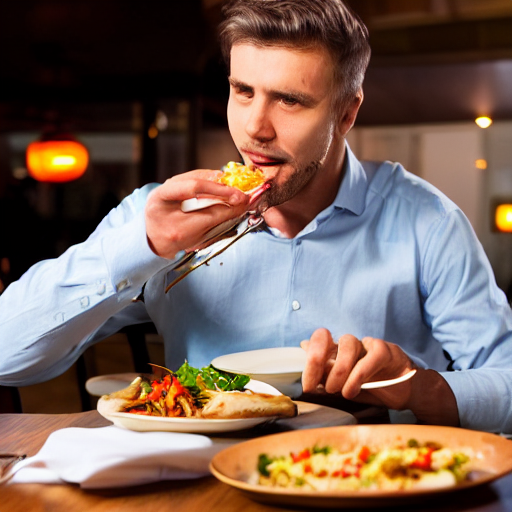

In [ ]:
prompt = 'a man having dinner at the restaurant'
torch.cuda.empty_cache()
latents = torch.randn((1, unet.in_channels, 512 // 8, 512 // 8))
img = prompt_to_img(prompt, num_inference_steps=20, latents=latents)[0]
img

In [ ]:
def perturb_latents(latents, scale=0.1):
  noise = torch.randn_like(latents)
  new_latents = (1 - scale) * latents + scale * noise
  return (new_latents - new_latents.mean()) / new_latents.std()

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

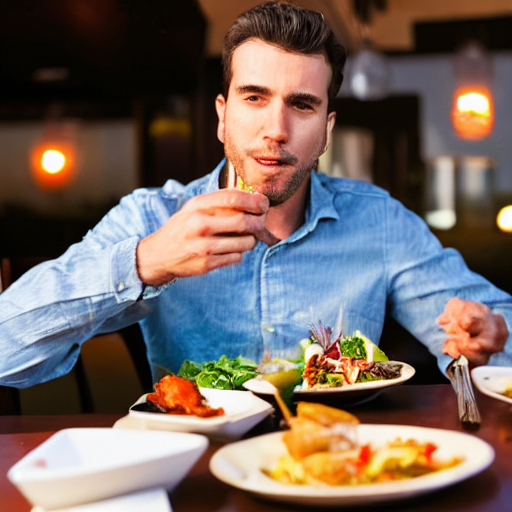

In [ ]:
new_latents = perturb_latents(latents, 0.4)
img = prompt_to_img(prompt, num_inference_steps=20, latents=new_latents)[0]
img

#Img to Img

In [ ]:
scheduler = LMSDiscreteScheduler(
    beta_start=0.00085, beta_end=0.012,
    beta_schedule='scaled_linear', num_train_timesteps=1000)

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

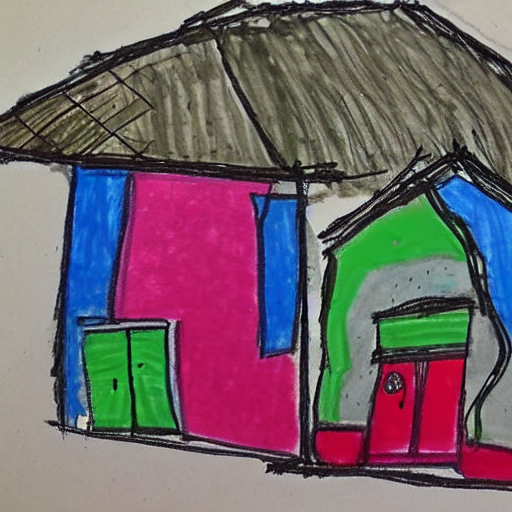

In [ ]:
prompt = 'a pooring house drawn by a child'
torch.cuda.empty_cache()
img = prompt_to_img(prompt, num_inference_steps=30)[0]
img

In [ ]:
def encode_img_latents(imgs):
  if not isinstance(imgs, list):
    imgs = [imgs]

  img_arr = np.stack([np.array(img) for img in imgs], axis=0)
  img_arr = img_arr / 255.0
  img_arr = torch.from_numpy(img_arr).float().permute(0, 3, 1, 2)
  img_arr = 2 * (img_arr - 0.5)

  latent_samples = vae.encode(img_arr.to(device)).latent_dist.sample()
  latent_samples *= 0.18215

  return latent_samples

In [ ]:
img_latents = encode_img_latents([img])

In [ ]:
# New scheduler for img-to-img
scheduler = DDIMScheduler(
    beta_start=0.00085, beta_end=0.012,
    beta_schedule='scaled_linear', num_train_timesteps=1000)

In [ ]:
def produce_latents(text_embeddings, height=512, width=512,
                    num_inference_steps=50, guidance_scale=7.5, latents=None,
                    return_all_latents=False, start_step=10):
  if latents is None:
    latents = torch.randn((text_embeddings.shape[0] // 2, unet.in_channels, \
                           height // 8, width // 8))
  latents = latents.to(device)

  scheduler.set_timesteps(num_inference_steps)
  if start_step > 0:
    start_timestep = scheduler.timesteps[start_step]
    start_timesteps = start_timestep.repeat(latents.shape[0]).long()

    noise = torch.randn_like(latents)
    latents = scheduler.add_noise(latents, noise, start_timesteps)

  latent_hist = [latents]
  with autocast('cuda'):
    for i, t in tqdm(enumerate(scheduler.timesteps[start_step:])):
      # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
      latent_model_input = torch.cat([latents] * 2)

      # predict the noise residual
      with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)['sample']

      # perform guidance
      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
      noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

      # compute the previous noisy sample x_t -> x_t-1
      latents = scheduler.step(noise_pred, t, latents)['prev_sample']
      latent_hist.append(latents)
  
  if not return_all_latents:
    return latents

  all_latents = torch.cat(latent_hist, dim=0)
  return all_latents

def prompt_to_img(prompts, height=512, width=512, num_inference_steps=50,
                  guidance_scale=7.5, latents=None, return_all_latents=False,
                  batch_size=2, start_step=0):
  if isinstance(prompts, str):
    prompts = [prompts]

  # Prompts -> text embeds
  text_embeds = get_text_embeds(prompts)

  # Text embeds -> img latents
  latents = produce_latents(
      text_embeds, height=height, width=width, latents=latents,
      num_inference_steps=num_inference_steps, guidance_scale=guidance_scale,
      return_all_latents=return_all_latents, start_step=start_step)
  
  # Img latents -> imgs
  all_imgs = []
  for i in tqdm(range(0, len(latents), batch_size)):
    imgs = decode_img_latents(latents[i:i+batch_size])
    all_imgs.extend(imgs)

  return all_imgs

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

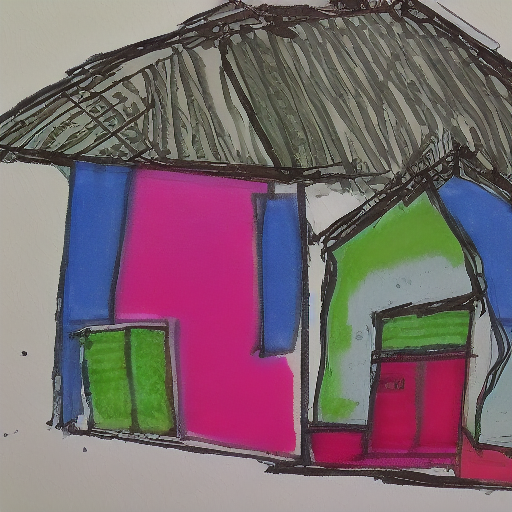

In [ ]:
prompt = 'a house 3D render'
img = prompt_to_img(prompt, num_inference_steps=30, latents=img_latents,
                    start_step=20)[0]
img

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

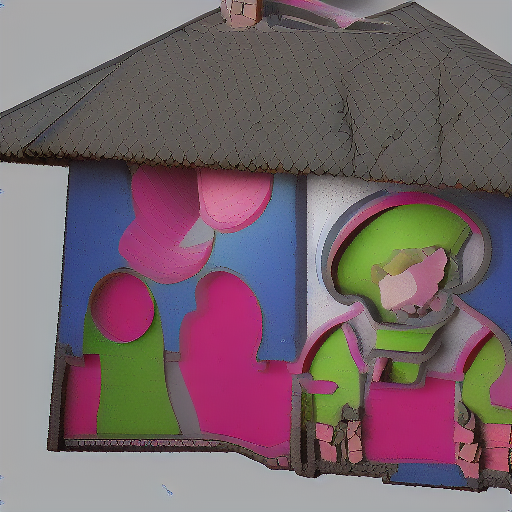

In [ ]:
prompt = 'a house 3D render'
img = prompt_to_img(prompt, num_inference_steps=30, latents=img_latents,
                    start_step=10)[0]
img